In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
import numpy as np

In [4]:
print (torch.__version__)

1.6.0


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [6]:
train = datasets.MNIST('/home/jd/Desktop/EVA5/secession5/', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('/home/jd/Desktop/EVA5/secession5/', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [7]:
batch_size = 128
learning_rate = 0.01

In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

 

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [9]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3),
            nn.ReLU()
        ) #OP image size  = 26 # Receptive field  = 3
        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3),
            nn.ReLU()
        ) # OP image size = 24 Receptive field = 5
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3),
            nn.ReLU()
        ) #OP image size  = 26 # Receptive field  = 3
        
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2) # OP image size = 12,Receptive field  = 10
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU()
        ) #OP image size  = 26 # Receptive field  = 3
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU()
        ) #OP image size  = 26 # Receptive field  = 3
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=1),
            nn.ReLU()
        ) #OP image size  = 26 # Receptive field  = 3
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU()
        )
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU()
        )
        
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=3)
        )
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)      
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = x.view(-1,10)
        return F.log_softmax(x)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,168
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 32, 22, 22]           4,640
              ReLU-6           [-1, 32, 22, 22]               0
         MaxPool2d-7           [-1, 32, 11, 11]               0
            Conv2d-8             [-1, 32, 9, 9]           9,248
              ReLU-9             [-1, 32, 9, 9]               0
           Conv2d-10             [-1, 64, 7, 7]          18,496
             ReLU-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 16, 7, 7]           1,040
             ReLU-13             [-1, 16, 7, 7]               0
           Conv2d-14             [

<ipython-input-9-8ccb887849e2>:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 16
for epoch in range(1,EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


<ipython-input-9-8ccb887849e2>:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Loss=2.275566816329956 Batch_id=468 Accuracy=11.30: 100%|██████████| 469/469 [00:12<00:00, 37.61it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2787, Accuracy: 1596/10000 (15.96%)

EPOCH: 2


Loss=0.17191185057163239 Batch_id=468 Accuracy=79.59: 100%|██████████| 469/469 [00:13<00:00, 35.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1243, Accuracy: 9597/10000 (95.97%)

EPOCH: 3


Loss=0.04466262459754944 Batch_id=468 Accuracy=95.94: 100%|██████████| 469/469 [00:12<00:00, 36.57it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0879, Accuracy: 9725/10000 (97.25%)

EPOCH: 4


Loss=0.1359032690525055 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:12<00:00, 37.89it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9805/10000 (98.05%)

EPOCH: 5


Loss=0.04675361514091492 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:11<00:00, 41.01it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 9845/10000 (98.45%)

EPOCH: 6


Loss=0.05538478493690491 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:11<00:00, 40.55it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9840/10000 (98.40%)

EPOCH: 7


Loss=0.06291847676038742 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:11<00:00, 41.19it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9882/10000 (98.82%)

EPOCH: 8


Loss=0.06492156535387039 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:11<00:00, 42.36it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9879/10000 (98.79%)

EPOCH: 9


Loss=0.015286285430192947 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:11<00:00, 41.24it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9874/10000 (98.74%)

EPOCH: 10


Loss=0.0578363798558712 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:11<00:00, 40.39it/s]   
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9888/10000 (98.88%)

EPOCH: 11


Loss=0.023113250732421875 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:11<00:00, 41.48it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9885/10000 (98.85%)

EPOCH: 12


Loss=0.010349711403250694 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:12<00:00, 38.98it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9890/10000 (98.90%)

EPOCH: 13


Loss=0.011144406162202358 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:11<00:00, 39.08it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9899/10000 (98.99%)

EPOCH: 14


Loss=0.009158913046121597 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:11<00:00, 39.23it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9889/10000 (98.89%)

EPOCH: 15


Loss=0.01644219644367695 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:11<00:00, 39.63it/s]  



Test set: Average loss: 0.0339, Accuracy: 9898/10000 (98.98%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Training Loss')

Text(0.5, 1.0, 'Training Accuracy')

Text(0.5, 1.0, 'Test Loss')

Text(0.5, 1.0, 'Test Accuracy')

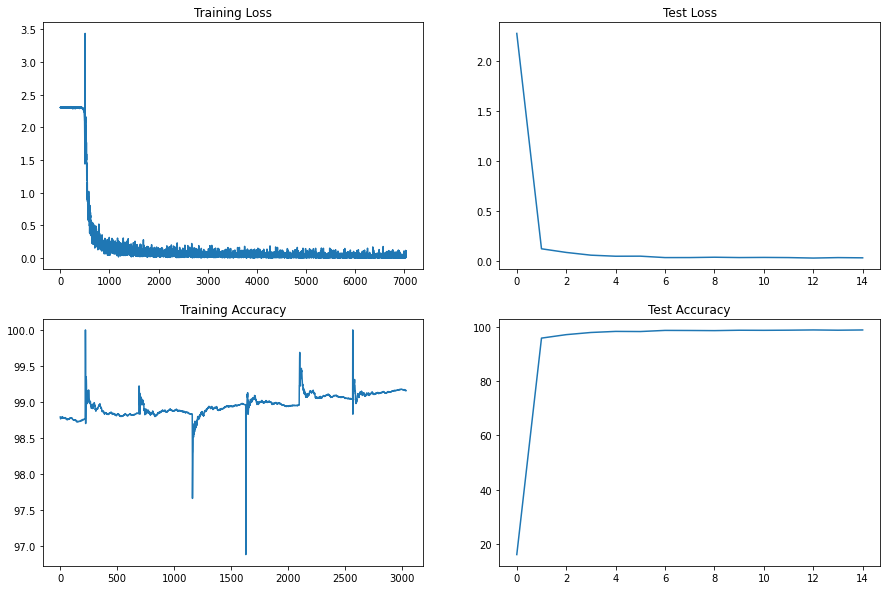

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [18]:
import pandas as pd

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [44]:
train_score= {'train_acc': train_acc , 'train_losses' : train_losses }
pd.DataFrame(train_score).describe()

,train_acc
count,7035.000000
mean,89.926282
std,23.695817
min,9.960938
25%,97.173747
50%,98.604230
75%,98.922366
max,100.000000


In [45]:
test_score = {'test_acc':test_acc,'test_losses':test_losses}
pd.DataFrame(test_score).describe()

,test_acc,test_losses
count,15.000000,15.000000
mean,92.928000,0.198519
std,21.308308,0.576005
min,15.960000,0.031614
25%,98.225000,0.036400
50%,98.790000,0.038050
75%,98.885000,0.055525
max,98.990000,2.278673
